In [1]:
# Preface
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
import numpy as np
from os.path import isdir
from os import makedirs

from collections import OrderedDict

%config Completer.use_jedi = False

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sys import path as syspath
syspath.append("./functions/")

from physio_def_1 import *

In [2]:
from matplotlib.colors import LogNorm

In [3]:
import pandas as pd

In [4]:
from plotFirst_1 import plotImage

In [5]:
pathToFile = '/Volumes/physio/team/slakrupnik/project/experiments/Sandra/20190812/Experiment28.lif'

md = bf.get_omexml_metadata(pathToFile)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
rdr = bf.ImageReader(pathToFile, perform_init=True)
extension = "."+pathToFile.split(".")[-1]

OrderedDict([(i,xml.image(i).Name) for i in range(Nimages)])

OrderedDict([(0, 'Image005'),
             (1, 'Image008'),
             (2, 'Image011'),
             (3, 'Image013'),
             (4, 'Series015'),
             (5, 'Image019'),
             (6, 'Image021'),
             (7, 'Series022'),
             (8, 'Image026'),
             (9, 'Image033'),
             (10, 'Series034'),
             (11, 'Image040'),
             (12, 'Series041'),
             (13, 'Series042'),
             (14, 'Image044'),
             (15, 'Image047'),
             (16, 'Image049'),
             (17, 'Image051'),
             (18, 'Series052'),
             (19, 'Series053'),
             (20, 'Series054'),
             (21, 'Series055'),
             (22, 'Series056'),
             (23, 'Series057'),
             (24, 'Series059'),
             (25, 'Image061'),
             (26, 'Series062'),
             (27, 'Image069'),
             (28, 'Series070'),
             (29, 'Series071'),
             (30, 'Image078'),
             (31, 'Series079'),
  

In [6]:
iSeries = 12

im = xml.image(iSeries)
Name = im.Name
dimensions = dict(zip("TXY",(getattr(im.Pixels, "Size"+dim) for dim in "TXY")))

if dimensions["T"]>1:
    dimensions['freq'] = getApparentFreq(iSeries,xml)

In [7]:
dimensions

{'T': 8000, 'X': 512, 'Y': 512, 'freq': 1.981011120610266}

In [8]:
howManyFirstFrames = 100
firstFrames = importFrames(rdr,idx=iSeries, which=(howManyFirstFrames,))

if len(firstFrames.shape)>3:
    print("There are more dimensions here than expected.\nI'll remedy this for now, but be shure to keep this in mind.")
    extraDims = True
    retainDims = np.where(firstFrames.std(axis=tuple(range(len(firstFrames.shape)-1)))>0)[0]
    assert len(retainDims)==1
    retainDims = retainDims[0]
    firstFrames = firstFrames.T[retainDims].T

meanFirstFrames = firstFrames.mean(axis=0)
stdFirstFrames = firstFrames.std(axis=0)

In [9]:
pxSize = im.Pixels.get_PhysicalSizeX()
pxUnit = im.Pixels.get_PhysicalSizeXUnit()
text = "\n".join([" %s:%i"%(c,dimensions[c])  for c in "XYT"])
if dimensions["T"]>1:
    text += "\n f:%.1f Hz"%dimensions['freq']

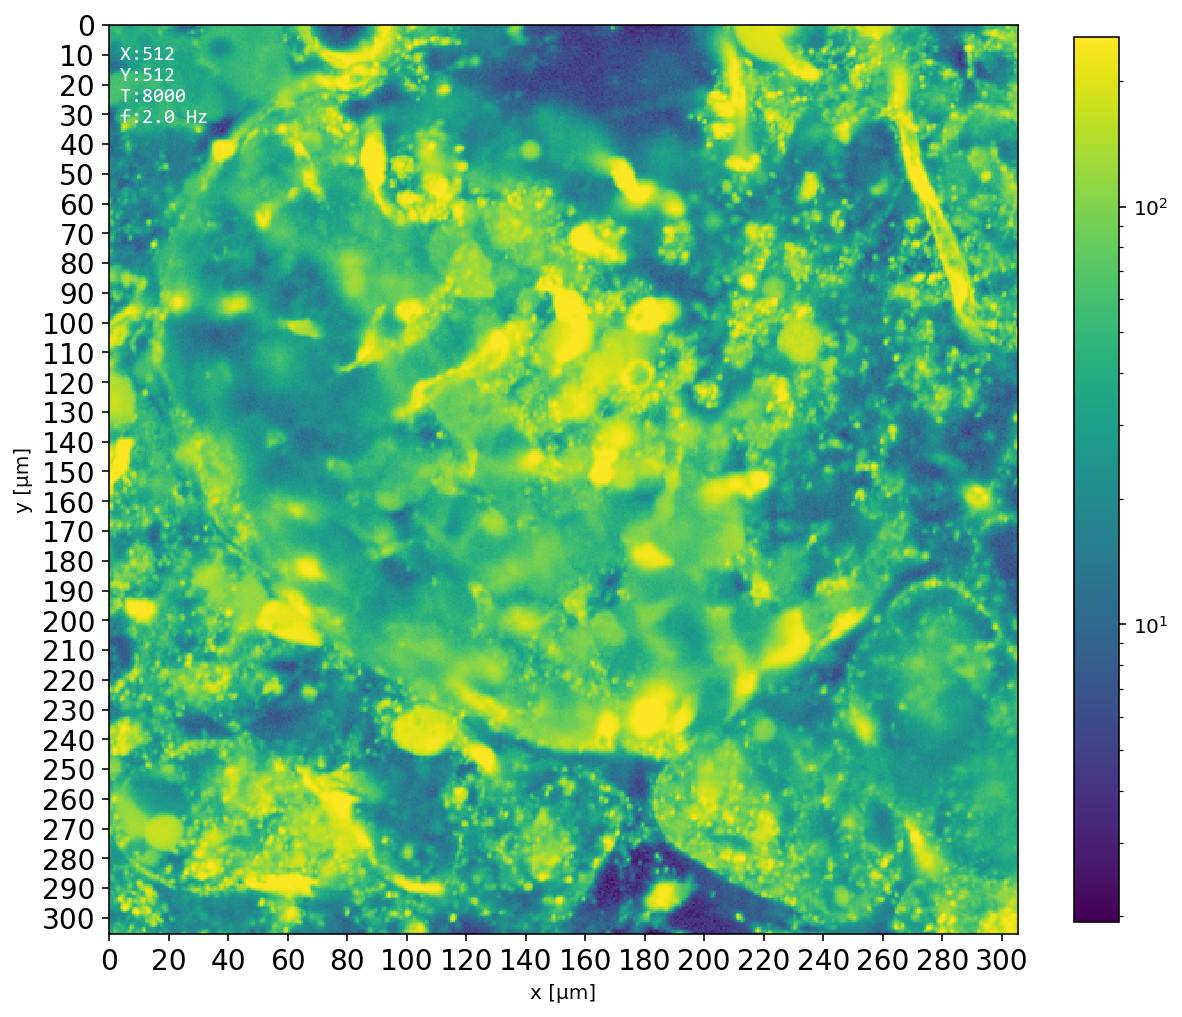

In [10]:
plotImage(meanFirstFrames.T,pxSize=pxSize,pxUnit=pxUnit,
          rescale=1./30,
          #savePath=pathToFile[:-4]+"_%s_first_mean.png"%(Name),
          addInfo=text)

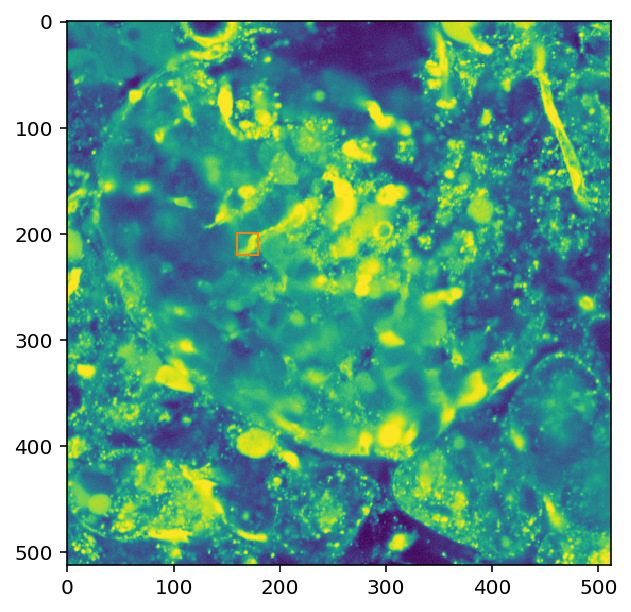

In [11]:
windowSize = 20
windowOrigin = (160,200)
plotImageWithRois([windowOrigin],windowSize,image_=firstFrames,imgHeight=5, label=False)

# Choose a patch to import all

In [12]:
# from sklearn import preprocessing
# normalizer = preprocessing.Normalizer()

In [13]:
%%time
importT = np.arange(0,dimensions["T"]//10)
subimage = importFrames(
    rdr,
    idx=iSeries,
    which=(importT,
        (windowOrigin[0],windowOrigin[0]+windowSize),
        (windowOrigin[1],windowOrigin[1]+windowSize),
          )
                       )

CPU times: user 1.87 s, sys: 334 ms, total: 2.21 s
Wall time: 19.8 s


In [14]:
time = getTimes(xml_=xml,idx_=iSeries)[importT]

In [15]:
pxSize

0.5962577299412916

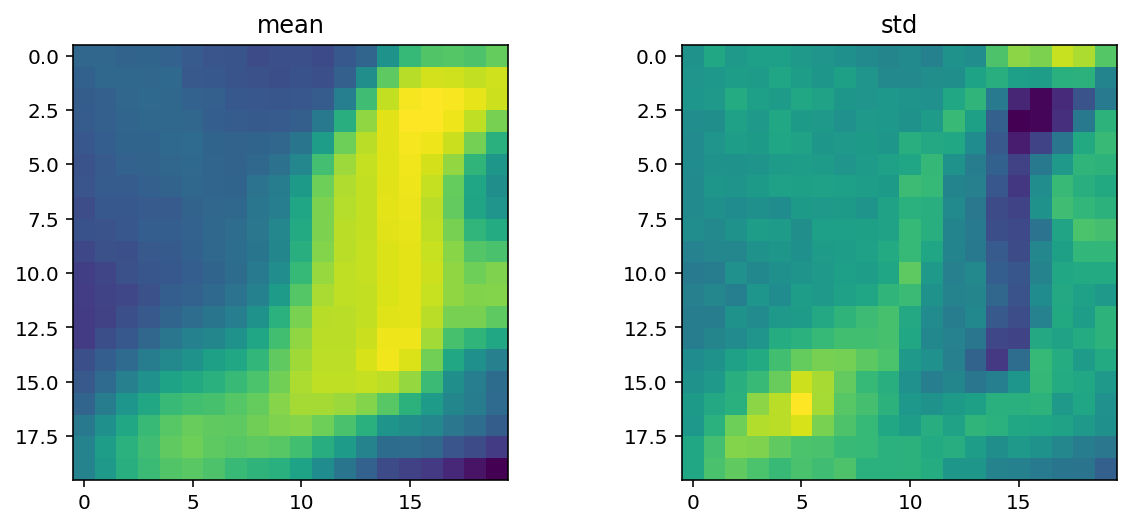

In [16]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
plotImageWithRois([],
            image_=subimage,
            stdDev=True,
            axs =axs,
            label=True
        );
for ax,name in zip(axs,["mean","std"]):
    ax.set_title(name)

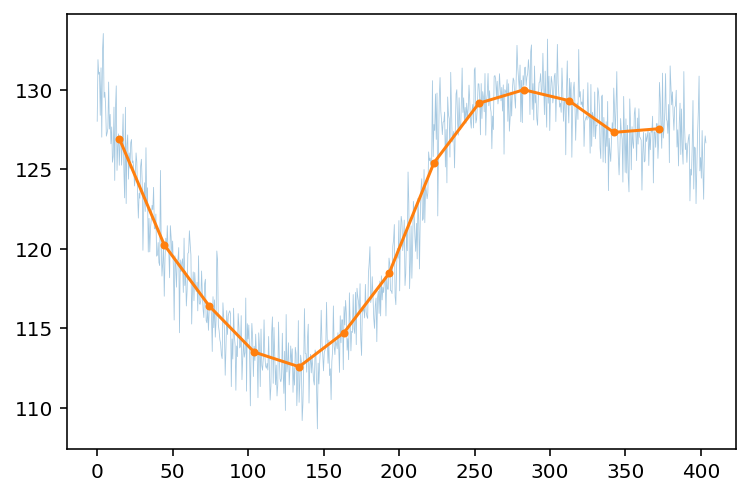

In [17]:
slowTimescale = 30 # in seconds
tWin=int(slowTimescale*dimensions["freq"])

plt.plot(time,subimage.mean(axis=(1,2)), lw=.4,alpha=.4)
plt.plot(rebin(time,tWin),rebin(subimage.mean(axis=(1,2)),tWin),".-")

# Clustering 

In [18]:
import scipy.cluster.hierarchy as spc

In [51]:
def showLinkageAndMatrices(linkage_,matrices_, figsize=5, fig=None, axs=None,threshold=None,scale=1):
    add = .3
    if fig is None:
        fig = plt.figure(figsize=np.array([len(matrices_)+0.15+add,1])*figsize)
    if axs is None:
        gs = fig.add_gridspec(1, len(matrices_)*2+1)
        axDnd = fig.add_subplot(gs[:1])
        axs = [axDnd]
        axs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=axDnd) for i in range(len(matrices_))]
    else:
        axDnd = axs[0]
        
    Z = linkage_.copy()
    Z[:,-2] *= scale
    dnd_ = spc.dendrogram(Z,
                         color_threshold=threshold*scale if threshold is not None else None,
                         ax=axDnd,
                         orientation="left")
#     if threshold is not None:
#         axDnd.axvline(threshold*scale,color="grey",lw=.6)
#     if scale>1:
#         axDnd.set_xscale("symlog")
#         xt = axDnd.get_xticks()
#         axDnd.set_xticklabels(xt/scale)
    rightOrder = dnd_["leaves"]
    ia = 1
    if "corr" in matrices_:
        D = matrices_["corr"][rightOrder].copy()
        D = D[:,rightOrder]
        ax = axs[ia]
        ax.imshow(D[::-1], vmin=-1,vmax=1,cmap="bwr_r", extent=(-.5,D.shape[0]-.5,)+axDnd.get_ylim())
        ax.set_title("corr. coefs")
        ax.set_aspect("auto")
        plt.setp(ax.get_yticklabels(), visible=False)
        ia += 1
    if "orig" in matrices_:
        X_ = matrices_['orig']
        ax = axs[ia]
        ax.imshow(X_[rightOrder],origin="bottom", extent=(-.5,X_.shape[1]-.5,)+axDnd.get_ylim())
        ax.set_aspect("auto")
        ax.set_title("time profiles")
    return dnd_

In [20]:
pxWin=1
pxShows = [(i*pxWin,j*pxWin) for i in range(subimage.shape[1]//pxWin) for j in range(subimage.shape[2]//pxWin)]
# pxShows = []a

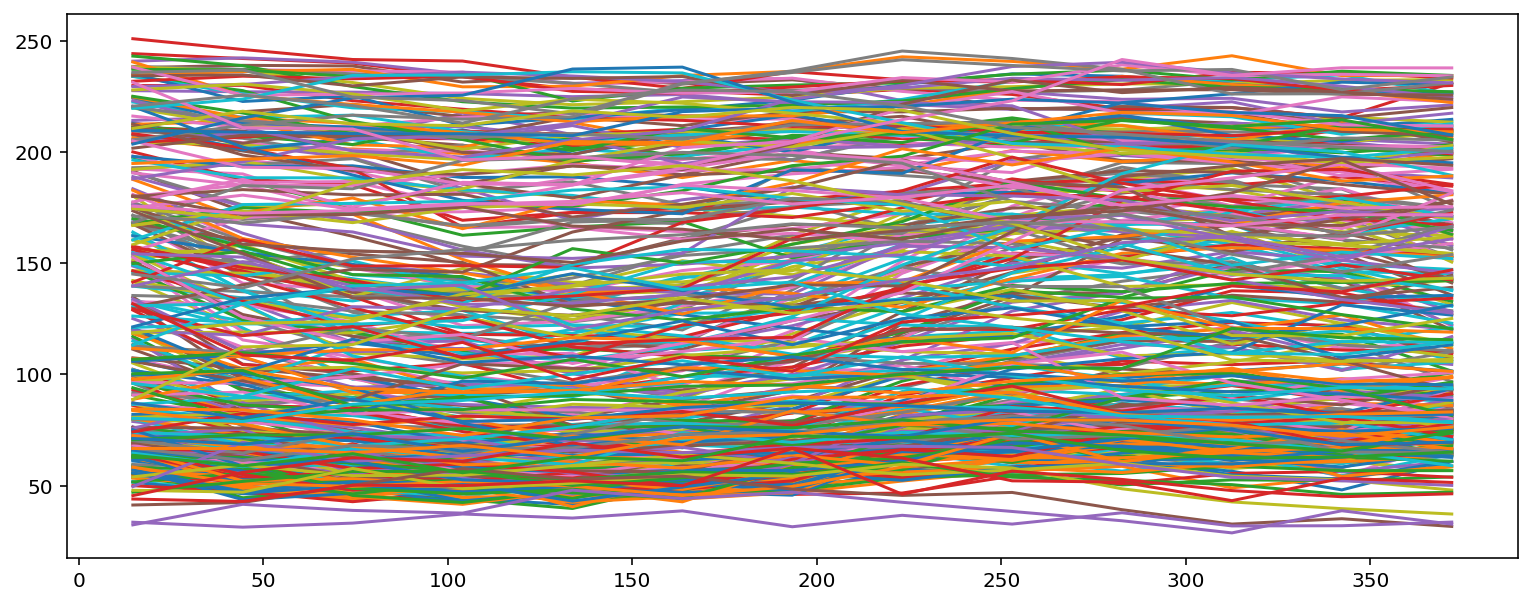

In [39]:
roiProfiles = getRoiProfiles(image_=subimage,pxShows=pxShows,pxWin=pxWin,tWin_=tWin)
slowTime = rebin(time,tWin)

fig = plt.figure(figsize=(13,5))
ax = plt.subplot(111)
for roiLabel in roiProfiles:
    ax.plot(slowTime,roiProfiles[roiLabel], label=roiLabel)
# ax.legend(ncol=len(roiProfiles)//20+1)

In [40]:
absMax = firstFrames.max()
print ("deteced saturation:",absMax)
X = np.vstack(list(roiProfiles.values()))
X[X>absMax*.8] = np.nan
filterValid = np.isfinite(X,).sum(1)>10
validPixels = np.array(list(roiProfiles.keys()))[np.isfinite(X,).sum(1)>10]
X = X[filterValid]

deteced saturation: 255.0


In [41]:
roiProfiles = OrderedDict(zip(np.arange(len(validPixels)),[roiProfiles[iv] for iv in validPixels]))

In [42]:
pxShows = [pxShows[iv] for iv in validPixels]

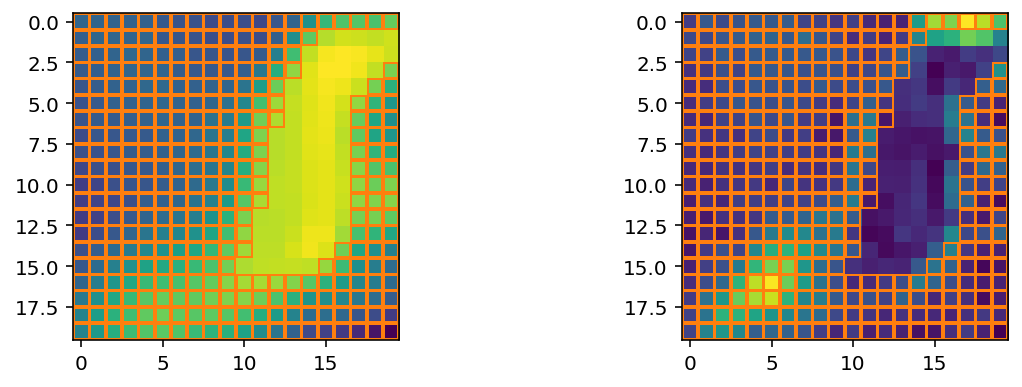

In [43]:
fig, axsUp = plt.subplots(1,2,figsize=(10,3))
# fig = plt.figure(figsize=(10,7))
# axsUp = [
#     fig.add_axes([0,.6,.4,.4]),
#     fig.add_axes([.41,.6,.4,.4])
# ]
plotImageWithRois(
            pxShows = pxShows,
            pxWin   = pxWin,
            image_=rebin(subimage[:,:,:],tWin),
            stdDev=True,
            axs =axsUp,
            label=False
        );

In [44]:
X.shape

(324, 13)

In [45]:
ppX = X.copy()
ppX = [x-np.nanmean(x) for x in ppX]
ppX = [x/np.nanstd(x) for x in ppX]
ppX = np.array(ppX)

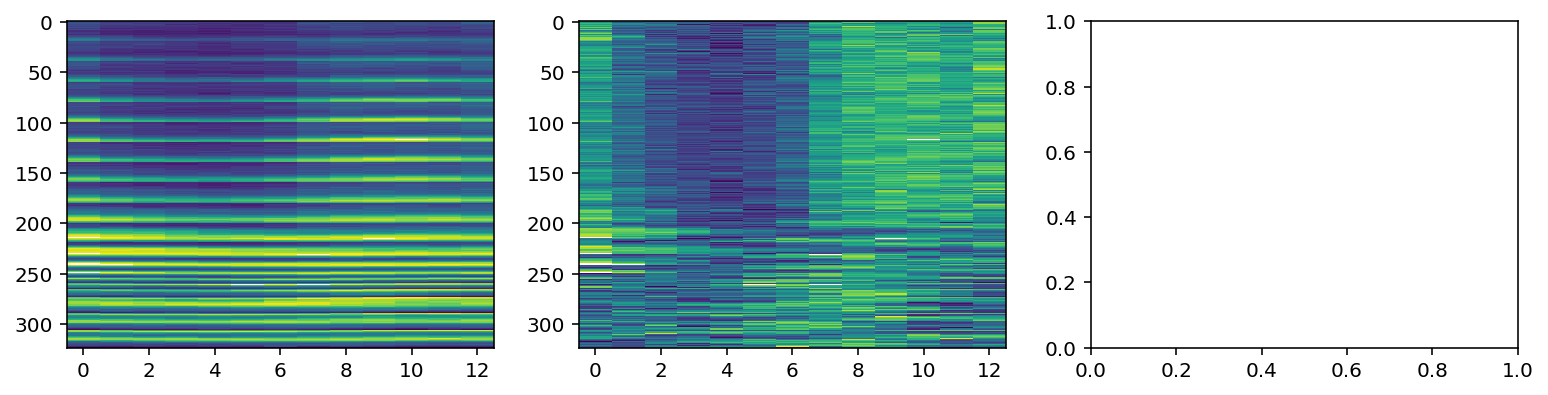

In [46]:
fig, axs = plt.subplots(1,3,figsize=(13,3))
for ax,x in zip(axs,[X,ppX]):    
    ax.imshow(x)
    ax.set_aspect("auto")


In [47]:
CorrCoefRaw = pd.DataFrame(X.T).corr().values

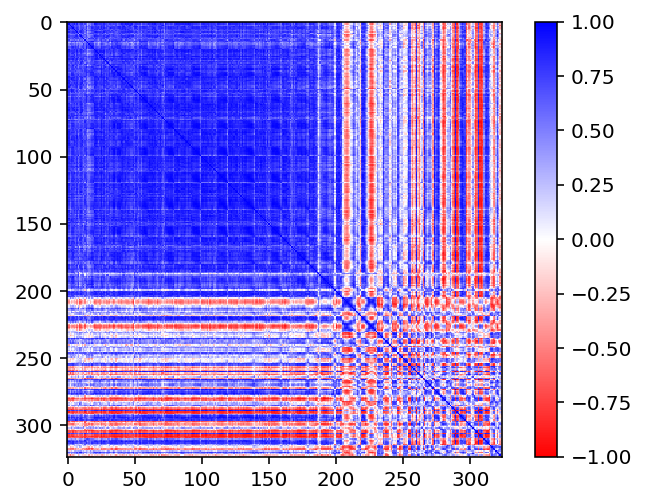

In [48]:
plt.imshow(CorrCoefRaw,vmin=-1,vmax=1,cmap="bwr_r")
plt.colorbar()

In [99]:
%%time
x = ppX[:]
Ncl = 4

method = "centroid"
metric = "correlation"
if metric=="correlation":
    Z = spc.linkage(1-CorrCoefRaw[np.triu_indices_from(CorrCoefRaw,1)],method=method,)
else:
    Z = spc.linkage(x, method=method, metric=metric)

CPU times: user 3.91 ms, sys: 1.51 ms, total: 5.42 ms
Wall time: 3.67 ms


CPU times: user 913 ms, sys: 4.84 ms, total: 918 ms
Wall time: 915 ms


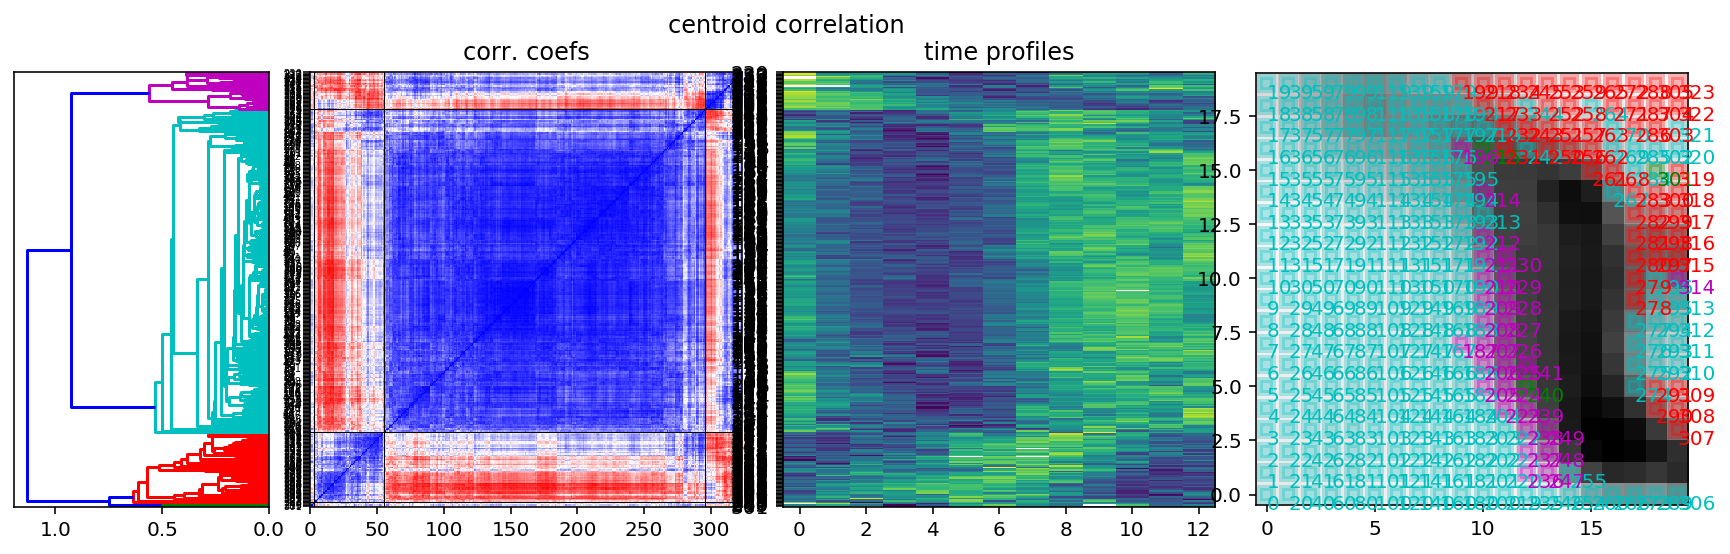

<Figure size 882x360 with 0 Axes>

In [113]:
%%time
fig = plt.figure(figsize=(15,4))
fig.suptitle(f"{method} {metric}"+" "*10)
gs=fig.add_gridspec(1, 7, width_ratios = [1.3]+[1]*6)
myaxs = [fig.add_subplot(gs[:1])]
myaxs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=myaxs[0]) for i in range(2)]
dnd = showLinkageAndMatrices(Z,
                             matrices_ = {"orig":x,"corr":CorrCoefRaw},
                             axs=myaxs,
                             threshold=Z[-Ncl+1,2],
#                              labels=validPixels
                            )
ax = fig.add_subplot(gs[-2:])
clrs = []
for jj,c in zip((np.array(dnd['icoord'])[:,1:3]-5)/10,dnd["color_list"]):
    for j in jj:
        if int(j)!=j or j>=len(x): continue
        k=dnd['leaves'][int(j)]
        if k in clrs: continue
        clrs += [{"leaf":k,"color":c}]
clrs = pd.DataFrame(clrs)
ax.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None,origin="bottom")
for c,js in clrs.groupby("color"):
    addRoisToImage(pxShows={j:pxShows[j] for j in js.leaf},ax=ax,pxWin=pxWin,
                   label=True,
                   dd=.4,
                   color=c,
                   rectangle_kw={"linewidth":3,"fill":True,"color":c,"alpha":.3})
ids = spc.fcluster(Z,criterion="maxclust",t=Ncl)
ax = myaxs[1]
for j in np.where(np.diff(ids[dnd["leaves"]]))[0]+1:
    ax.axhline(j*10+5, lw=.5,color="k")
    ax.axvline(j, lw=.5,color="k")

In [62]:
from collections import Counter

In [66]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_x_axes.join(target, ax)
        if sharey:
            target._shared_y_axes.join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

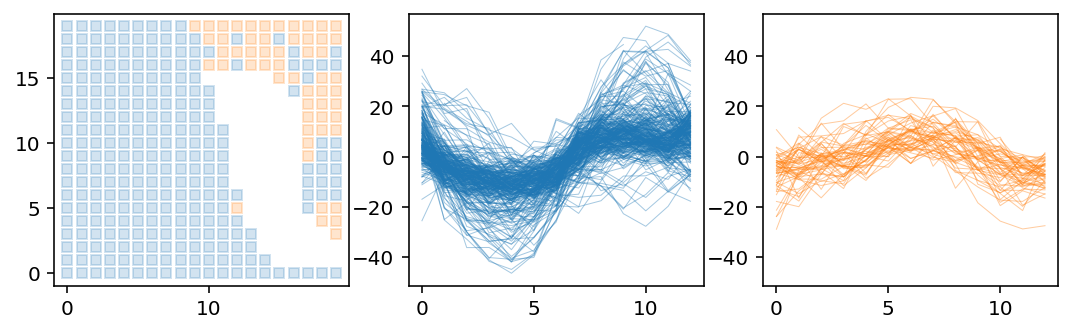

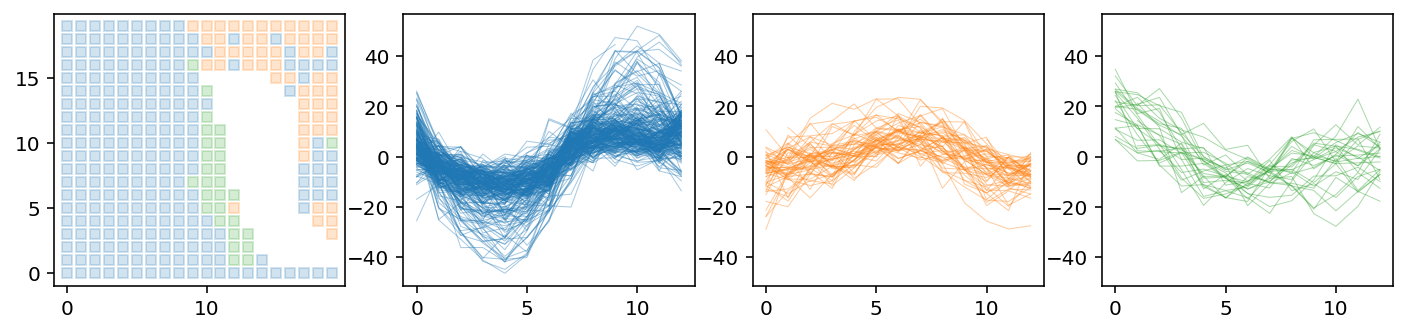

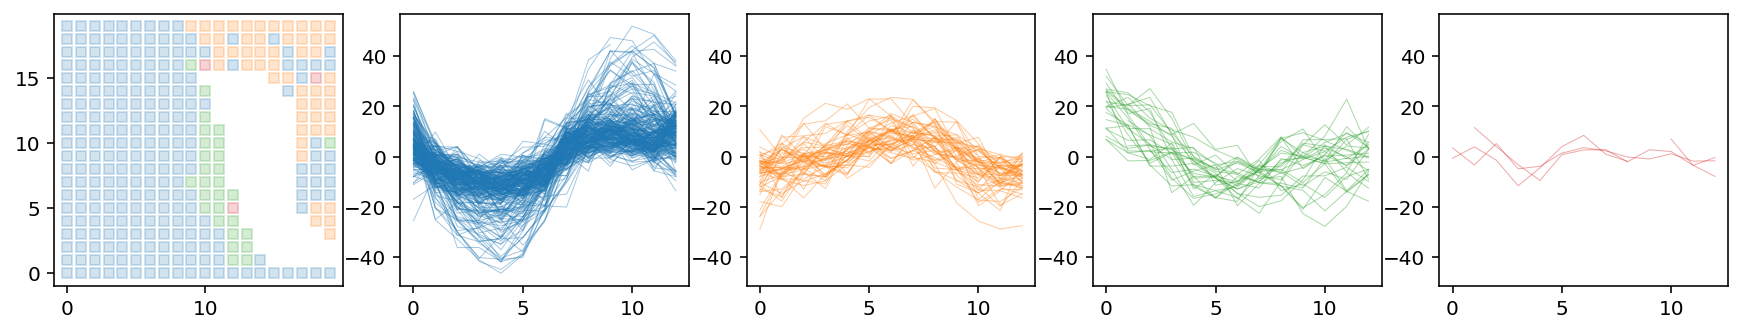

In [75]:
for ncl in [2,3,4]:
    ids = spc.fcluster(Z,criterion="maxclust",t=ncl)
    idCounts = OrderedDict(Counter(ids).most_common())
    
    fig, axs = plt.subplots(1,ncl+1,figsize=(3*(ncl+1),2.5))
    ax0 = axs[0]
    # ax0.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None)
    set_share_axes(axs[1:], sharey=True)
    for ic,i, ax in zip(range(ncl),idCounts.keys(),axs[1:]):
        fltr = ids==i
        c = "C%i"%(ic)
        for x in X[fltr]: 
            ax.plot(x-np.nanmean(x),color=c,lw=.5,alpha = .4)
        x,y = np.array(pxShows)[fltr].T-.5+pxWin/2
        ax0.plot(x,y,"s",c=c,alpha=.2,ms=5)

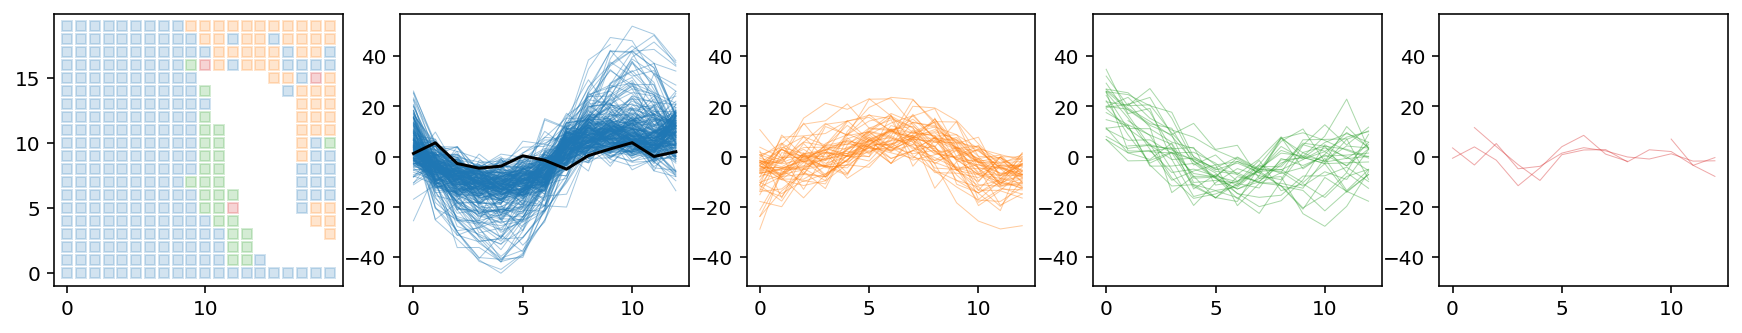

In [116]:

ids = spc.fcluster(Z,criterion="maxclust",t=ncl)
idCounts = OrderedDict(Counter(ids).most_common())

fig, axs = plt.subplots(1,ncl+1,figsize=(3*(ncl+1),2.5))
ax0 = axs[0]
# ax0.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None)
set_share_axes(axs[1:], sharey=True)
for ic,i, ax in zip(range(ncl),idCounts.keys(),axs[1:]):
    fltr = ids==i
    c = "C%i"%(ic)
    for x in X[fltr]: 
        ax.plot(x-np.nanmean(x),color=c,lw=.5,alpha = .4)
    x,y = np.array(pxShows)[fltr].T-.5+pxWin/2
    ax0.plot(x,y,"s",c=c,alpha=.2,ms=5)
for j in [310]:
    x = X[j]
    axs[1].plot(x-np.nanmean(x),color="k")

# PCA

In [90]:
def myPCA(data):
    '''
    Input:  2D numpy array where rows are observations
    Output: a tuple Eigenvalues, Eigenvetors
    '''
    from scipy import linalg as la
#     C = np.cov(data, rowvar=False)
    C = pd.DataFrame(data).cov()
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    vecs = vecs.T[::-1]
    datamean = np.nanmean(data,axis=0)
    for i in range(len(vals)):
        if datamean.dot(vecs[i])<0:
            vecs[i] = -vecs[i]
    return vals, vecs

In [91]:
def project(observation, vecs, obsmean = 0):
    return obsmean+np.sum([observation.dot(v)*v for v in vecs], axis=0)

In [92]:
vals, vecs = myPCA(ppX)
# vals, vecs = myPCA(ppX)

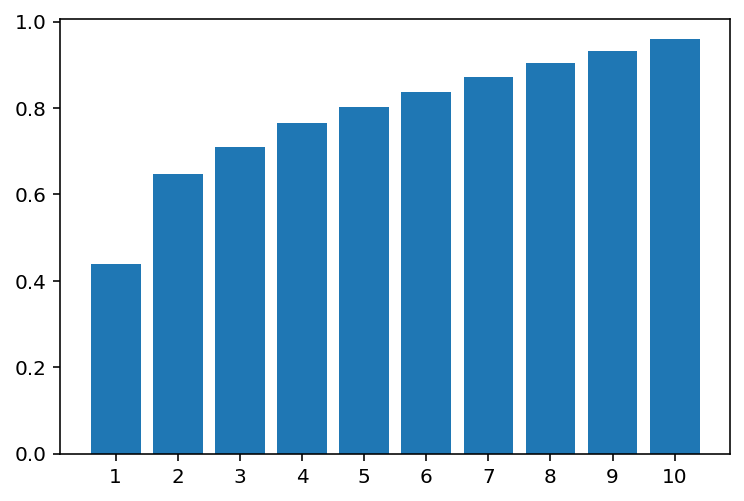

In [93]:
percVarExplained = np.cumsum(vals/sum(vals))
nComponents = np.where(percVarExplained<.99)[0][-1]
plt.bar(np.arange(nComponents)+1,percVarExplained[:nComponents])
plt.xticks(np.arange(nComponents)+1);

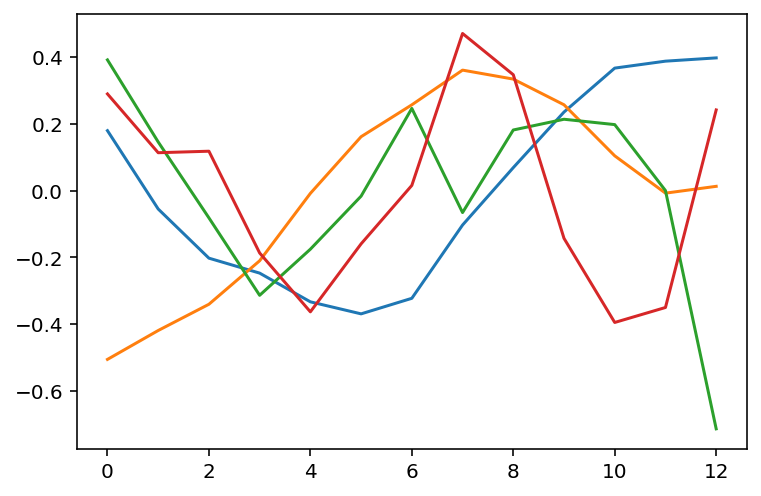

In [94]:
plt.plot(vecs[:min(nComponents,4),:].T)

In [124]:
def getProjections(data,vec):
    return np.array([[np.nanmean([a*b for a,b in zip(t,v)])*len(t) for v in vec] for t in data])

In [125]:
nComponents = 4
MtoPCA = ppX.copy()
projections = getProjections(MtoPCA,vecs[:nComponents])

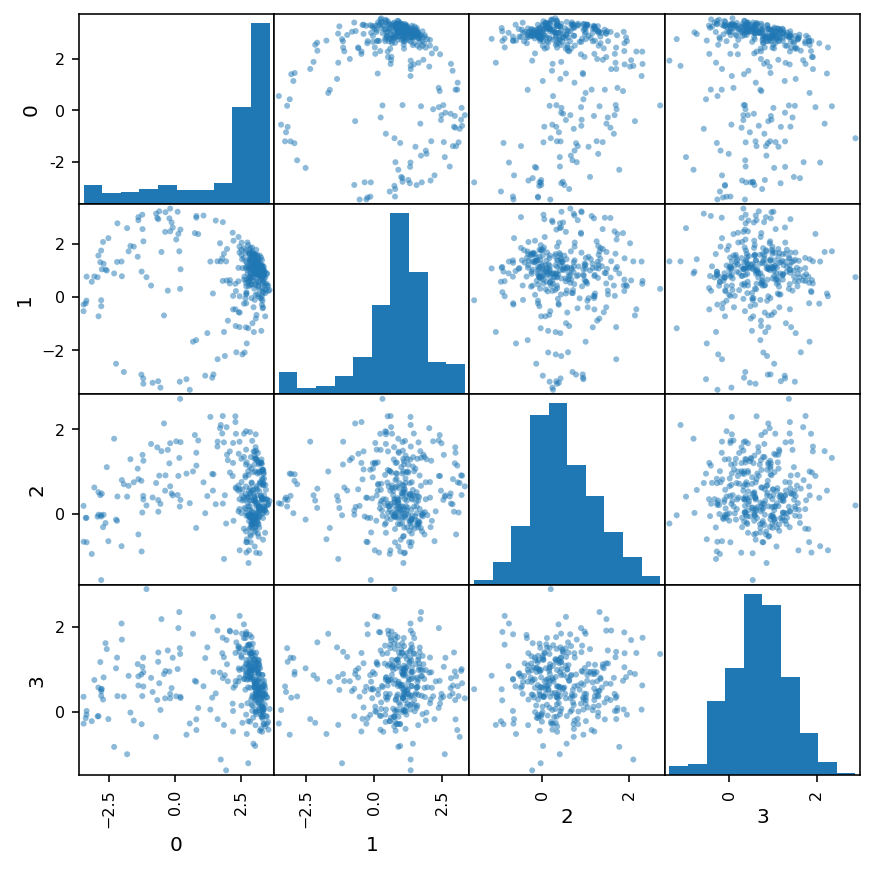

In [126]:
pd.plotting.scatter_matrix(pd.DataFrame(projections),figsize=(7,7));

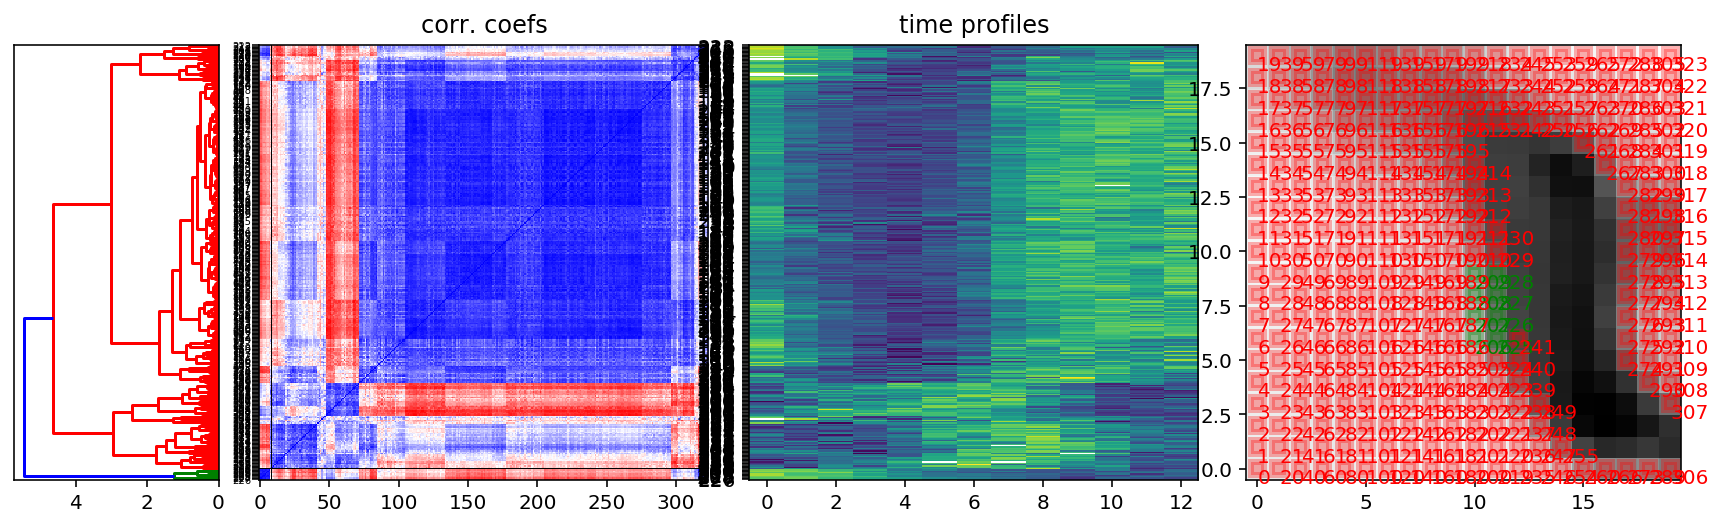

<Figure size 882x360 with 0 Axes>

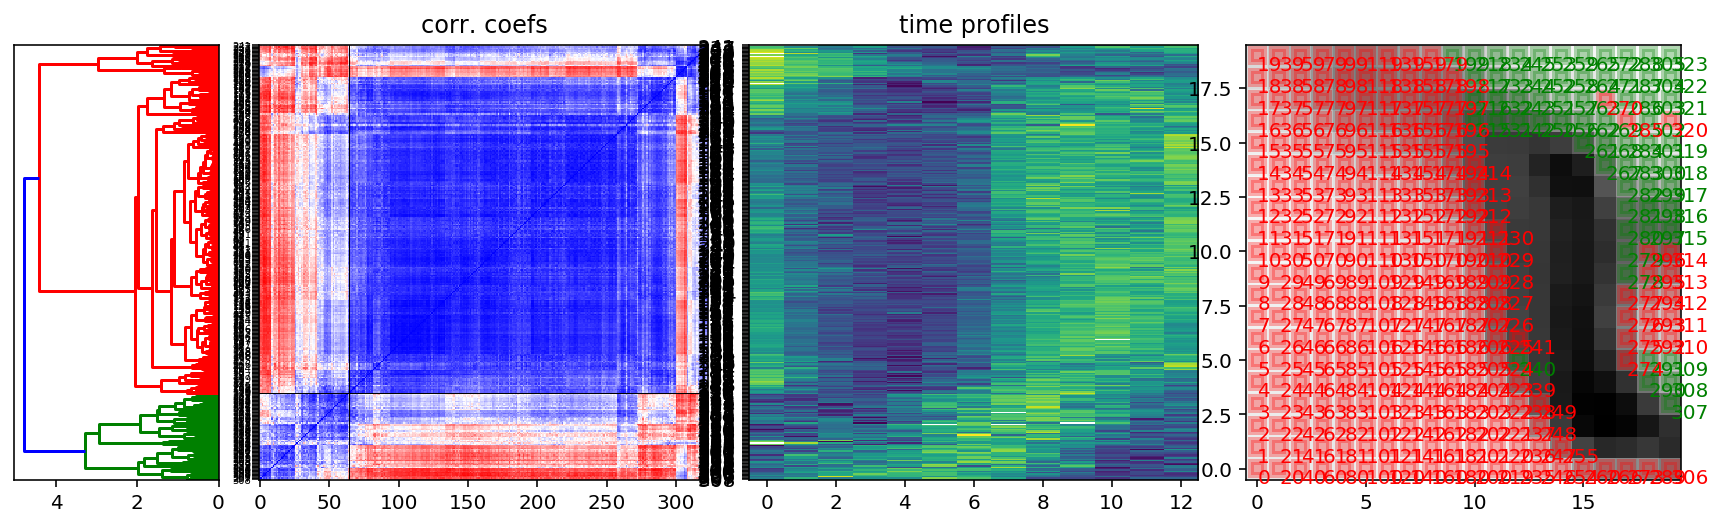

<Figure size 882x360 with 0 Axes>

In [130]:
MtoPCA = ppX.copy()
vals, vecs = myPCA(ppX)
Ncl = 2
for nComponents in [2,3]:
    projections = getProjections(MtoPCA,vecs[:nComponents])
#     proj = normalizer.fit_transform(projections.T).T
    proj = projections
    linkage = spc.linkage(proj, method='average', metric="euclidean")
    
    fig = plt.figure(figsize=(15,4))
    gs=fig.add_gridspec(1, 7, )
    myaxs = [fig.add_subplot(gs[:1])]
    myaxs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=myaxs[0]) for i in range(2)]
    dnd = showLinkageAndMatrices(linkage,matrices_ = {"orig":MtoPCA,"corr":CorrCoefRaw},axs=myaxs,threshold=linkage[-Ncl+1,2])
    ax = fig.add_subplot(gs[-2:])
    clrs = []
    for jj,c in zip((np.array(dnd['icoord'])[:,1:3]-5)/10,dnd["color_list"]):
        for j in jj:
            if int(j)!=j or j>=len(MtoPCA): continue
            k=dnd['leaves'][int(j)]
            if k in clrs: continue
            clrs += [{"leaf":k,"color":c}]
    clrs = pd.DataFrame(clrs)
    ax.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None,origin="bottom")
    for c,js in clrs.groupby("color"):
        addRoisToImage(pxShows={j:pxShows[j] for j in js.leaf},ax=ax,pxWin=pxWin,
                       label=True,
                       dd=.4,
                       color=c,
                       rectangle_kw={"linewidth":3,"fill":True,"color":c,"alpha":.3})
    ids = spc.fcluster(linkage,criterion="maxclust",t=Ncl)
    ax = myaxs[1]
    for j in np.where(np.diff(ids[dnd["leaves"]]))[0]+1:
        ax.axhline(j*10+5, lw=.5,color="k")
        ax.axvline(j, lw=.5,color="k")